# Solutions-03

This contains one possible solution for the three-parameter linear model with intrinsic scatter.

Recall that we are working with this data:

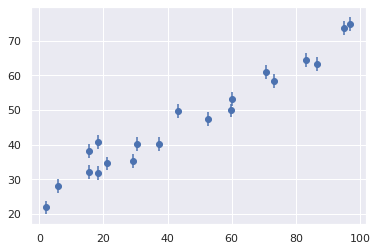

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set() # for plot formatting

def make_data_scatter(intercept, slope, scatter,
                      N=20, dy=2, rseed=42):
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(20)
    y = intercept + slope * x
    y += np.sqrt(dy ** 2 + scatter ** 2) * rand.randn(20)
    return x, y, dy * np.ones_like(x)


# (intercept, slope, intrinsic scatter)
theta = (25, 0.5, 3.0)
x, y, dy = make_data_scatter(*theta)
plt.errorbar(x, y, dy, fmt='o');

### Define the prior, likelihood, and posterior

The likelihood for this model looks very similar to what we used above, except that the intrinsic scatter is added *in quadrature* to the measurement error.
If $\varepsilon_i$ is the measurement error on the point $(x_i, y_i)$, and $\sigma$ is the intrinsic scatter, then the likelihood should look like this:

$$
P(x_i,y_i\mid\theta) = \frac{1}{\sqrt{2\pi(\varepsilon_i^2 + \sigma^2)}} \exp\left(\frac{-\left[y_i - y(x_i;\theta)\right]^2}{2(\varepsilon_i^2 + \sigma^2)}\right)
$$

For the prior, you can use either a flat or symmetric prior on the slope and intercept, but on the intrinsic scatter $\sigma$ it is best to use a scale-invariant Jeffreys Prior:

$$
P(\sigma)\propto\sigma^{-1}
$$

As discussed before, this has the nice feature that the resulting posterior will not depend on the units of measurement.

In [2]:
# Define functions to compute the log-prior, log-likelihood, and log-posterior

# theta = [intercept, slope, scatter]

def log_prior(theta):
    if theta[2] <= 0 or np.any(np.abs(theta[:2]) > 1000):
        return -np.inf  # log(0)
    else:
        # Jeffreys Prior
        return -np.log(theta[2])
    
def log_likelihood(theta, x, y, dy):
    y_model = theta[0] + theta[1] * x
    S = dy ** 2 + theta[2] ** 2
    return -0.5 * np.sum(np.log(2 * np.pi * S) +
                         (y - y_model) ** 2 / S)

def log_posterior(theta, x, y, dy):
    return log_prior(theta) + log_likelihood(theta, x, y, dy)

### Sampling from the Posterior

In [3]:
# Using emcee, create and initialize a sampler and draw 200 samples from the posterior.
# Remember to think about what starting guesses should you use!
# You can use the above as a template

import emcee

ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers

# initialize walkers
starting_guesses = np.random.randn(nwalkers, ndim)
starting_guesses[:, 2] = np.random.rand(nwalkers)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,
                                args=[x, y, dy])
pos, prob, state = sampler.run_mcmc(starting_guesses, 200)

### Visualizing the Chains

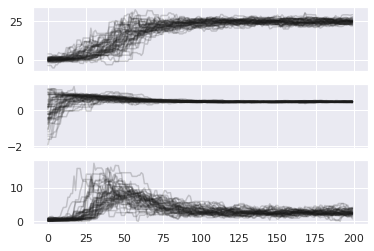

In [4]:
# Plot the three chains as above

fig, ax = plt.subplots(3, sharex=True)
for i in range(3):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);

### Restarting and getting a clean sample

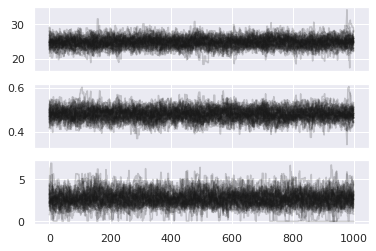

In [5]:
# Are your chains stabilized? Reset them and get a clean sample

sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000)

fig, ax = plt.subplots(3, sharex=True)
for i in range(3):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);

### Visualizing the results

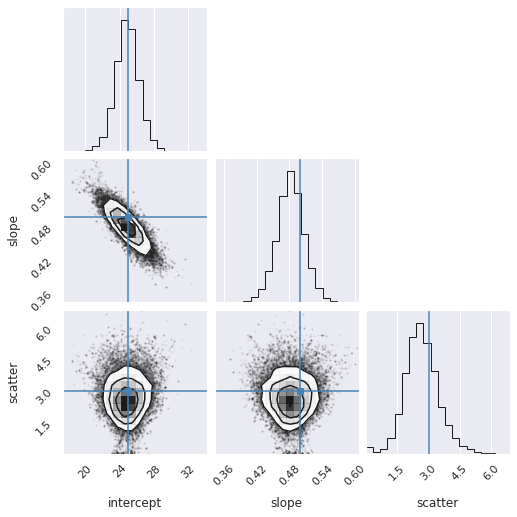

In [6]:
# Use corner.py to visualize the three-dimensional posterior

import corner
corner.corner(sampler.flatchain, truths=theta,
              labels=['intercept', 'slope', 'scatter']);

And visualizing the model over the data:

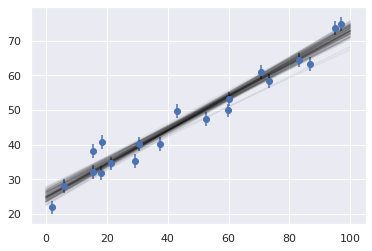

In [7]:
# Next plot ~100 of the samples as models over the data to get an idea of the fit

chain = sampler.flatchain

plt.errorbar(x, y, dy, fmt='o');

thetas = [chain[i] for i in np.random.choice(chain.shape[0], 100)]

xfit = np.linspace(0, 100)
for i in range(100):
    theta = thetas[i]
    plt.plot(xfit, theta[0] + theta[1] * xfit,
             color='black', alpha=0.05);